[[0.8  0.71 0.52 0.31 0.13]
 [0.4  0.53 0.66 0.73 0.81]
 [0.7  0.61 0.48 0.18 0.11]]


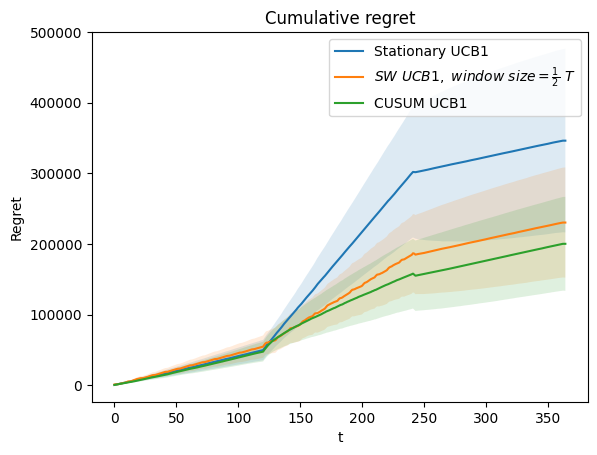

[[0.81 0.73 0.53 0.28 0.13]
 [0.4  0.48 0.65 0.76 0.79]
 [0.68 0.59 0.46 0.2  0.11]]


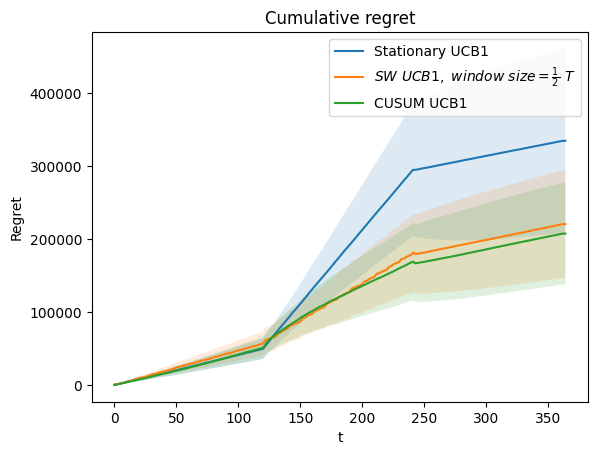

[[0.88 0.71 0.54 0.3  0.12]
 [0.39 0.5  0.64 0.75 0.8 ]
 [0.7  0.6  0.46 0.18 0.1 ]]


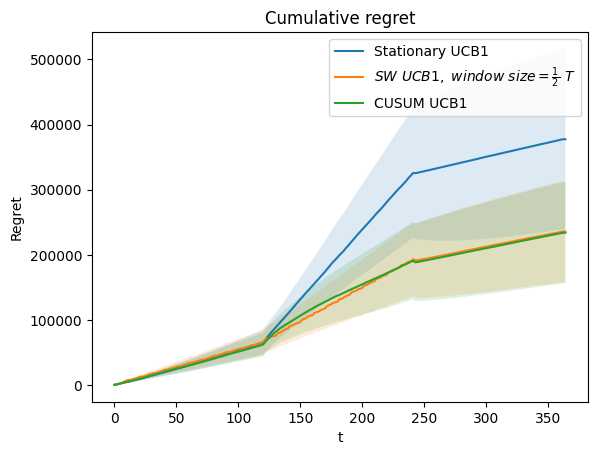

[[0.85 0.78 0.53 0.3  0.18]
 [0.39 0.52 0.66 0.74 0.81]
 [0.72 0.6  0.46 0.2  0.11]]


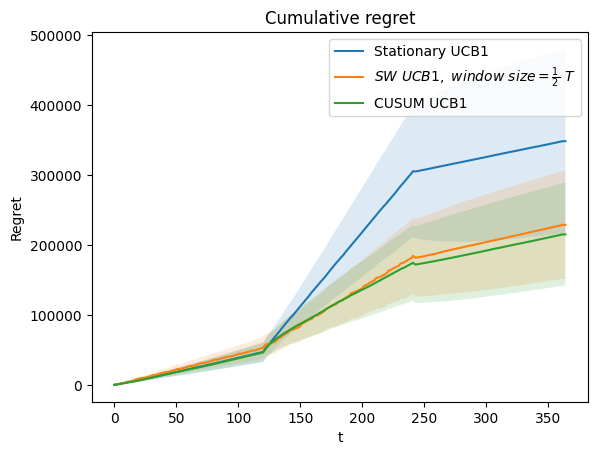

[[0.9  0.68 0.51 0.31 0.11]
 [0.41 0.49 0.66 0.74 0.8 ]
 [0.68 0.6  0.47 0.18 0.08]]


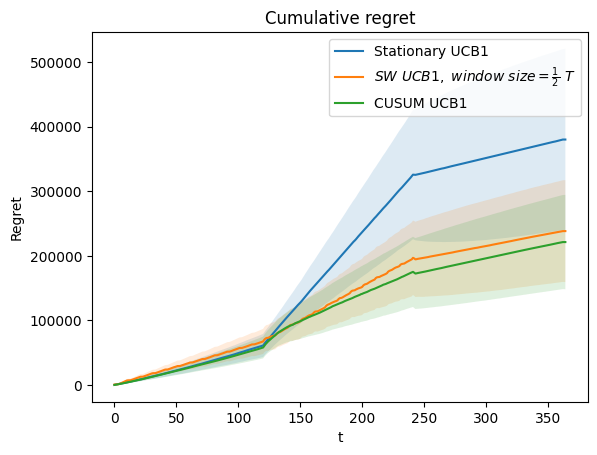

In [7]:
from Customer import *
from Environment import Non_Stationary_Environment
from Learners import UCB1_Learner_ns as UCB1_Learner
from Learners import SWUCB_Learner
from Learners import CDUCB_Learner
from plotter import Plotter
import numpy as np
from math import sqrt
import json

with open('probabilities.json', 'r') as file:
    probabilities = json.load(file)

for prb in probabilities['prb_step5']:
    prb = np.array(prb)
    c1 = Customer('C1', -0.0081, 0.97, 32, 3.8, -1.5, 0.1, 100)
    prices = np.array([10, 20, 30, 40, 50])

    T = 365
    n_experiments = 50
    n_arms = len(prices)
    n_phases = 3
    phases_len = int(T / n_phases)

    # UCB1, SWUCB1, CUSUM
    n_alg = 3

    margin = (prices - 8)
    clicks = int(c1.num_clicks(2))
    cost = c1.click_cost(2)
    rewards = (margin * prb - cost) * clicks

    opt_per_phase = rewards.max(axis=1)
    optimum_per_round = np.zeros(T)

    # window_size
    M = 10
    # exploration term
    eps = 0.2
    # detection threshold
    h = 10 * np.log(T)
    # scaling
    alpha = 0.1

    rewards_experiment = [[] for _ in range(n_alg)]

    for e in range(0, n_experiments):
        env = [Non_Stationary_Environment(prb, T, n_phases) for _ in range(n_alg)]
        
        learner = [
            UCB1_Learner(n_arms, prices, margin, clicks, cost),
            SWUCB_Learner(n_arms, prices, int(0.5 * sqrt(T)), margin, clicks, cost),
            CDUCB_Learner(n_arms, prices, M, eps, h, alpha, margin, clicks, cost)
        ]
        
        for t in range(0, T):
            for i in range(n_alg):
                pulled_arm = learner[i].pull_arm()
                reward = env[i].round(pulled_arm, clicks)
                learner[i].update(pulled_arm, reward)
        [rewards_experiment[i].append(learner[i].collected_rewards) for i in range(n_alg)]
    rewards_experiment = [np.array(rewards_experiment[i]) for i in range(n_alg)]

    regret = [np.zeros(T) for _ in range(n_alg)]
    std_regret = [np.zeros(T) for _ in range(n_alg)]

    for i in range(n_phases):
        t_index = range(i * phases_len, (i + 1) * phases_len)
        optimum_per_round[t_index] = opt_per_phase[i]
        for alg in range(n_alg):
            # Regret
            regret[alg][t_index] = np.mean(opt_per_phase[i] - rewards_experiment[alg], axis=0)[t_index]
    # Cumulative regret
    cum_regret = [np.cumsum(regret[i]) for i in range(n_alg)]
    # Standard deviation cumulative regret
    cumstd_regret = [[(np.cumsum(regret[alg]))[:i].std() for i in range(1, T + 1)] for alg in range(n_alg)]

    print(f"{prb}")

    # Plot results
    dataset = np.array([[
        [cum_regret[i], cumstd_regret[i]]
    ] for i in range(n_alg)])

    titles = ["Cumulative regret"]

    ucb1_label = "Stationary UCB1"
    swucb_label = r"$SW\ UCB1,\ window\ size=\frac{1}{2}\ T$"
    cducb_label = "CUSUM UCB1"
    labels = [ucb1_label, swucb_label, cducb_label]

    plotter = Plotter(dataset, optimum_per_round, titles, labels, T)
    plotter.plots()